<a href="https://colab.research.google.com/github/umamaheshwari1010/House_price_project/blob/main/House_price_prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [26]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [27]:
train_data = train_data[train_data['GrLivArea'] < 4000]

In [29]:
# Split data before preprocessing to prevent leakage
X = train_data.drop(['Id', 'SalePrice'], axis=1)
y = train_data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = np.log1p(y_train)  # Log-transform target immediately
y_test = np.log1p(y_test)

In [30]:
print("Missing values in train_data before imputation:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])

Missing values in train_data before imputation:
LotFrontage      221
Alley           1094
MasVnrType       685
MasVnrArea         5
BsmtQual          30
BsmtCond          30
BsmtExposure      31
BsmtFinType1      30
BsmtFinType2      30
Electrical         1
FireplaceQu      535
GarageType        64
GarageYrBlt       64
GarageFinish      64
GarageQual        64
GarageCond        64
PoolQC          1159
Fence            942
MiscFeature     1118
dtype: int64


In [31]:
# Impute LotFrontage with median (expanded to all numerical columns)
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
num_imputer = SimpleImputer(strategy='median')
X_train[numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = num_imputer.transform(X_test[numerical_cols])

In [32]:
# Impute categorical columns with 'None' (expanded to all categorical columns)
categorical_cols = X_train.select_dtypes(include=['object']).columns
cat_imputer = SimpleImputer(strategy='constant', fill_value='None')
X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])

In [33]:
# Verify missing values are handled
print("Missing values in X_train after imputation:")
print(X_train.isnull().sum().sum())  # Should be 0

Missing values in X_train after imputation:
0


In [34]:
# Feature engineering (as you requested)
X_train['TotalSF'] = X_train['GrLivArea'] + X_train['TotalBsmtSF']
X_test['TotalSF'] = X_test['GrLivArea'] + X_test['TotalBsmtSF']
X_train['HouseAge'] = X_train['YrSold'] - X_train['YearBuilt']
X_test['HouseAge'] = X_test['YrSold'] - X_test['YearBuilt']
X_train['Has2ndFloor'] = (X_train['2ndFlrSF'] > 0).astype(int)
X_test['Has2ndFloor'] = (X_test['2ndFlrSF'] > 0).astype(int)

In [35]:
numerical_cols = numerical_cols.append(pd.Index(['TotalSF', 'HouseAge']))

In [36]:
# One-hot encode categorical columns
print("Categorical columns:", categorical_cols)
# Filter categorical_cols to include only columns present in X_train
categorical_cols_present = [col for col in categorical_cols if col in X_train.columns]
print("Categorical columns present in X_train:", categorical_cols_present)
X_train = pd.get_dummies(X_train, columns=categorical_cols_present, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols_present, drop_first=True)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

Categorical columns: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
Categorical columns present in X_train: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation

In [37]:
numerical_cols = numerical_cols.append(pd.Index(['2ndFlrSF']))  # Include 2ndFlrSF
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [39]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Train models on log-transformed target
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained")

Linear Regression trained
Random Forest trained
XGBoost trained


In [41]:
# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name} RMSE: {rmse}")


Linear Regression RMSE: 0.8542642747053799
Random Forest RMSE: 0.14783464471488372
XGBoost RMSE: 0.15159803685702214


In [42]:
# Cross-validation for XGBoost
best_model = XGBRegressor(random_state=42)
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Individual Fold RMSEs:", -scores)
print(f"Cross-Validated RMSE: {-scores.mean():.4f}")

Individual Fold RMSEs: [0.13875349 0.13746792 0.14946741 0.13738406 0.10713393]
Cross-Validated RMSE: 0.1340


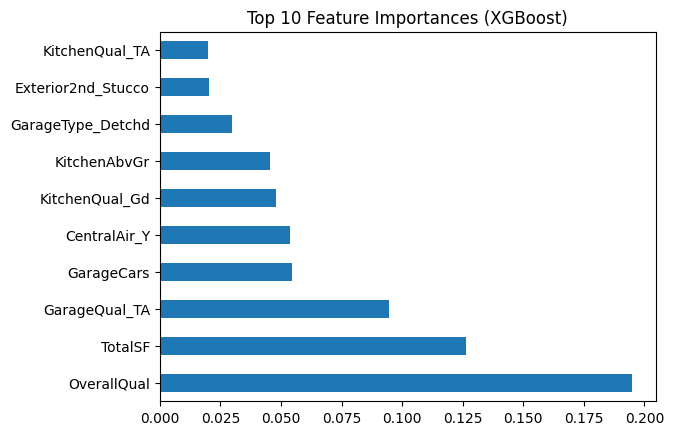

In [44]:
import matplotlib.pyplot as plt
best_model.fit(X_train, y_train)
feature_importance = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importance[:10].plot(kind='barh')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()